In [2]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/Colab Notebooks")

Mounted at /content/drive


In [4]:
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND #Hint: this is useful when defining the modified attention mechanism

With the default config, you can get 10-15% dev WER within 20 epochs. Each epoch will take 5 secs on a GPU and 10 secs on CPU

In [5]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=None):
        """
        Initialize Attention.
        ----
        enc_dim: encoder hidden state dimension
        dec_dim: decoder hidden state dimension
        attn_dim: attention feature dimension
        """
        super(Attention, self).__init__()
        if enc_dim == dec_dim and attn_dim is None:
            self.use_default = True
        elif attn_dim is not None:
            self.use_default = False
            self.attn_dim = attn_dim
            self.enc_dim = enc_dim
            self.dec_dim = dec_dim
            self.v = LinearND(self.attn_dim, 1, bias=False)
            self.W1 = LinearND(self.enc_dim, self.attn_dim, bias=False)
            self.W2 = nn.Linear(self.dec_dim, self.attn_dim, bias=False)
        else:
            raise ValueError("invalid args (enc_dim={}, dec_dim={}, attn_dim={})".format(enc_dim, dec_dim, attn_dim))

    def forward(self, eh, dhx, ax=None):
        """
        Forward Attention method.
        ----
        eh (FloatTensor): the encoder hidden state with
            shape (batch size, time, hidden dimension).
        dhx (FloatTensor): one time step of the decoder hidden
            state with shape (batch size, hidden dimension).
        ax (FloatTensor): one time step of the attention vector.
        ----
        Returns the context vectors (sx) and the corresponding attention alignment (ax)
        """
        
        if self.use_default:
            # Compute inner product of decoder slice with every encoder slice
            pax = torch.sum(eh * dhx, dim=2)
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax.unsqueeze(2), dim=1, keepdim=True)
        else:
            # TODO: Modify the attention mechanism
            pax = self.v(nn.functional.tanh((self.W1(eh)+self.W2(dhx))))
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax, dim=1, keepdim=True)
        return sx, ax

In [6]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.mean(losses)

def evaluate(model, ldr, preproc):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    return np.mean(losses), compute_wer(results)

In [7]:
"""
Use the development set to tune your model.
"""

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

Training RNN


In [8]:
def tunning(lr = opt_cfg["learning_rate"], encoder_size = model_cfg["encoder"]["hidden_size"], decoder_size = model_cfg["decoder"]["hidden_size"], sample_prob = config['model']['sample_prob']):
  attention = Attention(encoder_size, decoder_size)
  model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
  model = model.cuda() if use_cuda else model.cpu()
  model.sample_prob = sample_prob

  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=opt_cfg["momentum"])

  log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

  best_so_far = float("inf")
  dev_result = np.zeros((3,opt_cfg["max_epochs"]))
  for ep in range(opt_cfg["max_epochs"]):
      start = time.time()
    
      train_loss = train(model, optimizer, train_ldr)    
      dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)

      dev_result[0,ep] = train_loss
      dev_result[1,ep] = dev_loss
      dev_result[2,ep] = dev_wer
    
      print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    
      torch.save(model, os.path.join(config["save_path"], str(ep)))
    
      if dev_wer < best_so_far:
          best_so_far = dev_wer
          best_tloss = train_loss
          best_dloss = dev_loss
          torch.save(model, os.path.join(config["save_path"], "best"))
  return best_so_far, best_tloss, best_dloss, dev_result

In [ ]:
# TODO: tune on the dev set
# may want to set up function or chunk of code here to perform tuning
# call train on training set, call evaluate on dev, save/plot/compare results

In [16]:
# first do the base case
best_so_far, best_tloss, best_dloss, dev_result = tunning()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.49, dev_loss=  4.94 with  81.79% WER (  4.51s elapsed)
epoch    2 | train_loss=  4.17, dev_loss=  3.99 with  70.18% WER (  4.54s elapsed)
epoch    3 | train_loss=  3.58, dev_loss=  3.42 with  60.00% WER (  4.57s elapsed)
epoch    4 | train_loss=  2.90, dev_loss=  2.63 with  44.64% WER (  4.59s elapsed)
epoch    5 | train_loss=  2.80, dev_loss=  2.64 with  42.14% WER (  4.48s elapsed)
epoch    6 | train_loss=  2.47, dev_loss=  2.45 with  43.57% WER (  4.53s elapsed)
epoch    7 | train_loss=  1.49, dev_loss=  4.08 with  55.54% WER (  4.54s elapsed)
epoch    8 | train_loss=  1.31, dev_loss=  0.83 with  13.04% WER (  4.59s elapsed)
epoch    9 | train_loss=  0.88, dev_loss=  1.09 with  18.57% WER (  4.52s elapsed)
epoch   10 | train_loss=  0.80, dev_loss=  2.38 with  40.89% WER (  4.55s elapsed)
epoch   11 | train_loss=  1.08, dev_loss=  0.72 with   9.82% WER (  4.53s elapsed)
epoch   12 | train_loss=  0.54, dev_loss=  1.17 with  18.75% WER (  4.49s elapsed)
epoc

In [20]:
print('the best wer error is {:.2f}, train loss is {:.2f} ;and dev loss is {:.2f}.'.format(best_so_far, best_tloss, best_dloss))

the best wer error is 0.07, train loss is 0.28 ;and dev loss is 0.43.


In [9]:
import matplotlib.pyplot as plt

plot for base case (loss and wer vs epoch)


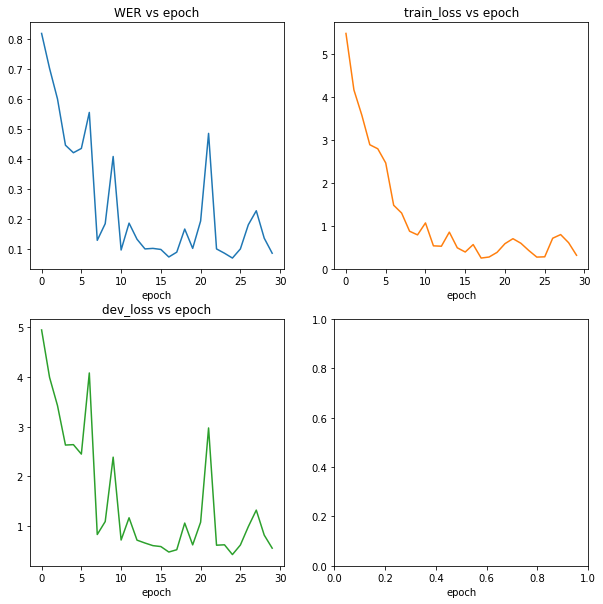

In [24]:
mesh = np.arange(30)
print('plot for base case (loss and wer vs epoch)')
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, dev_result[2])
axs[0, 0].set_title('WER vs epoch')
axs[0, 1].plot(mesh, dev_result[0], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, dev_result[1], 'tab:green')
axs[1, 0].set_title('dev_loss vs epoch')

for ax in axs.flat:
    ax.set(xlabel='epoch')

In [32]:
# Now, we change the value of sample probability
prob_list = np.array([0.3,0.6,0.9])
dloss = np.zeros(3)
tloss = np.zeros(3)
WERlist = np.zeros(3)

for i in range(3):
  print(' ')
  print('The sample probability is {:.2f}'.format(prob_list[i]))
  best_so_far, best_tloss, best_dloss, dev_result = tunning(sample_prob=prob_list[i])
  dloss[i] = best_dloss
  tloss[i] = best_tloss
  WERlist[i] = best_so_far

 
The sample probability is 0.30


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.26, dev_loss=  4.25 with  79.64% WER (  4.46s elapsed)
epoch    2 | train_loss=  3.77, dev_loss=  3.33 with  71.25% WER (  4.61s elapsed)
epoch    3 | train_loss=  3.29, dev_loss=  2.60 with  55.54% WER (  4.58s elapsed)
epoch    4 | train_loss=  2.61, dev_loss=  2.98 with  55.18% WER (  4.64s elapsed)
epoch    5 | train_loss=  2.00, dev_loss=  1.75 with  30.89% WER (  4.65s elapsed)
epoch    6 | train_loss=  1.72, dev_loss=  1.83 with  36.07% WER (  4.67s elapsed)
epoch    7 | train_loss=  1.02, dev_loss=  1.16 with  21.43% WER (  4.60s elapsed)
epoch    8 | train_loss=  0.94, dev_loss=  1.10 with  20.18% WER (  4.65s elapsed)
epoch    9 | train_loss=  0.77, dev_loss=  1.39 with  28.39% WER (  4.62s elapsed)
epoch   10 | train_loss=  0.74, dev_loss=  0.81 with  14.46% WER (  4.63s elapsed)
epoch   11 | train_loss=  0.49, dev_loss=  0.62 with  11.07% WER (  4.59s elapsed)
epoch   12 | train_loss=  0.38, dev_loss=  0.64 with  11.07% WER (  4.67s elapsed)
epoc

plots for losses and WER vs sample probability


Text(0, 0.5, 'loss')

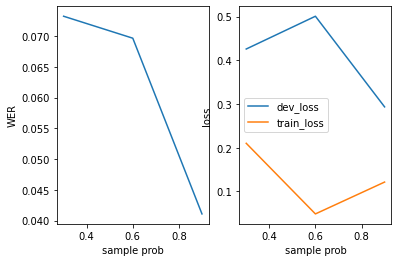

In [35]:
print('plots for losses and WER vs sample probability')

plt.subplot(1, 2, 1)
plt.plot(prob_list, WERlist)
plt.xlabel('sample prob')
plt.ylabel('WER')
plt.subplot(1, 2, 2)
plt.plot(prob_list, dloss,label='dev_loss')
plt.plot(prob_list, tloss,label='train_loss')
plt.legend()
plt.xlabel('sample prob')
plt.ylabel('loss')


In [36]:
print(WERlist)

[0.07321429 0.06964286 0.04107143]


In [14]:
# Now, we change the value of learning rate, fixed sample_prob=0.9
lr_list = np.array([0.1,0.5,0.8,1])
dloss = np.zeros(4)
tloss = np.zeros(4)
WERlist = np.zeros(4)

for i in range(4):
  print(' ')
  print('The learning rate is {:.2f}'.format(lr_list[i]))
  best_so_far, best_tloss, best_dloss, dev_result = tunning(lr=lr_list[i],sample_prob=0.9)
  dloss[i] = best_dloss
  tloss[i] = best_tloss
  WERlist[i] = best_so_far

 
The learning rate is 0.10


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.85, dev_loss=  6.53 with  89.11% WER (  6.66s elapsed)
epoch    2 | train_loss=  5.09, dev_loss=  5.98 with  87.86% WER (  6.60s elapsed)
epoch    3 | train_loss=  4.97, dev_loss=  5.23 with  85.00% WER (  6.50s elapsed)
epoch    4 | train_loss=  4.76, dev_loss=  4.77 with  84.46% WER (  6.54s elapsed)
epoch    5 | train_loss=  4.61, dev_loss=  4.62 with  83.04% WER (  6.66s elapsed)
epoch    6 | train_loss=  4.55, dev_loss=  4.56 with  80.71% WER (  6.73s elapsed)
epoch    7 | train_loss=  4.44, dev_loss=  4.47 with  78.57% WER (  6.60s elapsed)
epoch    8 | train_loss=  4.24, dev_loss=  4.38 with  76.25% WER (  6.58s elapsed)
epoch    9 | train_loss=  4.05, dev_loss=  4.27 with  69.29% WER (  6.80s elapsed)
epoch   10 | train_loss=  3.90, dev_loss=  4.14 with  68.75% WER (  7.10s elapsed)
epoch   11 | train_loss=  3.79, dev_loss=  4.04 with  69.64% WER (  6.54s elapsed)
epoch   12 | train_loss=  3.67, dev_loss=  3.93 with  65.71% WER (  6.54s elapsed)
epoc

plots for losses and WER vs learning rate


Text(0, 0.5, 'loss')

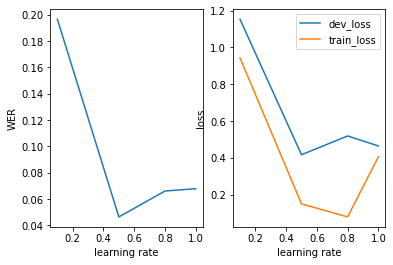

In [15]:
print('plots for losses and WER vs learning rate')

plt.subplot(1, 2, 1)
plt.plot(lr_list, WERlist)
plt.xlabel('learning rate')
plt.ylabel('WER')
plt.subplot(1, 2, 2)
plt.plot(lr_list, dloss,label='dev_loss')
plt.plot(lr_list, tloss,label='train_loss')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('loss')

In [16]:
print(WERlist)

[0.19642857 0.04642857 0.06607143 0.06785714]


In [17]:
# the best case is when learning rate=0.5 and sample prob=0.9
best_so_far, best_tloss, best_dloss, dev_result = tunning(lr=0.5, sample_prob=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.33, dev_loss=  4.73 with  82.68% WER (  6.74s elapsed)
epoch    2 | train_loss=  4.47, dev_loss=  4.24 with  82.14% WER (  6.44s elapsed)
epoch    3 | train_loss=  4.04, dev_loss=  3.97 with  74.46% WER (  6.52s elapsed)
epoch    4 | train_loss=  3.86, dev_loss=  3.66 with  65.89% WER (  6.68s elapsed)
epoch    5 | train_loss=  3.66, dev_loss=  3.61 with  63.04% WER (  6.77s elapsed)
epoch    6 | train_loss=  3.45, dev_loss=  3.37 with  59.46% WER (  6.51s elapsed)
epoch    7 | train_loss=  3.09, dev_loss=  3.13 with  58.93% WER (  6.44s elapsed)
epoch    8 | train_loss=  2.91, dev_loss=  2.74 with  45.71% WER (  6.54s elapsed)
epoch    9 | train_loss=  2.49, dev_loss=  2.38 with  40.71% WER (  6.51s elapsed)
epoch   10 | train_loss=  2.03, dev_loss=  1.81 with  30.54% WER (  6.60s elapsed)
epoch   11 | train_loss=  1.62, dev_loss=  1.51 with  27.32% WER (  6.46s elapsed)
epoch   12 | train_loss=  1.21, dev_loss=  1.88 with  30.54% WER (  7.40s elapsed)
epoc

In [18]:
print("Testing RNN")
test_model = torch.load(os.path.join(config["save_path"], "best"))
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])

_, test_wer = evaluate(test_model, test_ldr, preproc)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


4.52% WER (test)
